In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper import plot_anomalies
from Dataset import DatasetLoader
from pyanomaly.stats import MAD, Tukey
from pyanomaly.timeseries import moving_average, moving_average_score, \
                                    twitter, twitter_score

In [5]:
loader = DatasetLoader()
#loader.print_all()

In [4]:
ds_names = loader.get_list('realKnownCause')
ds_names

['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

## Preprocessamento

In [30]:
df_raw, labels = loader.load('cpu_utilization_asg_misconfiguration.csv')
df_raw.head()

,value
timestamp,
2014-05-14 01:14:00,85.835
2014-05-14 01:19:00,88.167
2014-05-14 01:24:00,44.595
2014-05-14 01:29:00,56.282
2014-05-14 01:34:00,36.534


In [31]:
df_raw.index.min(), df_raw.index.max(), df_raw.shape

(Timestamp('2014-05-14 01:14:00'),
 Timestamp('2014-07-15 17:19:00'),
 (18050, 1))

In [32]:
pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq='5T')

DatetimeIndex(['2014-05-14 01:14:00', '2014-05-14 01:19:00',
               '2014-05-14 01:24:00', '2014-05-14 01:29:00',
               '2014-05-14 01:34:00', '2014-05-14 01:39:00',
               '2014-05-14 01:44:00', '2014-05-14 01:49:00',
               '2014-05-14 01:54:00', '2014-05-14 01:59:00',
               ...
               '2014-07-15 16:34:00', '2014-07-15 16:39:00',
               '2014-07-15 16:44:00', '2014-07-15 16:49:00',
               '2014-07-15 16:54:00', '2014-07-15 16:59:00',
               '2014-07-15 17:04:00', '2014-07-15 17:09:00',
               '2014-07-15 17:14:00', '2014-07-15 17:19:00'],
              dtype='datetime64[ns]', length=18050, freq='5T')

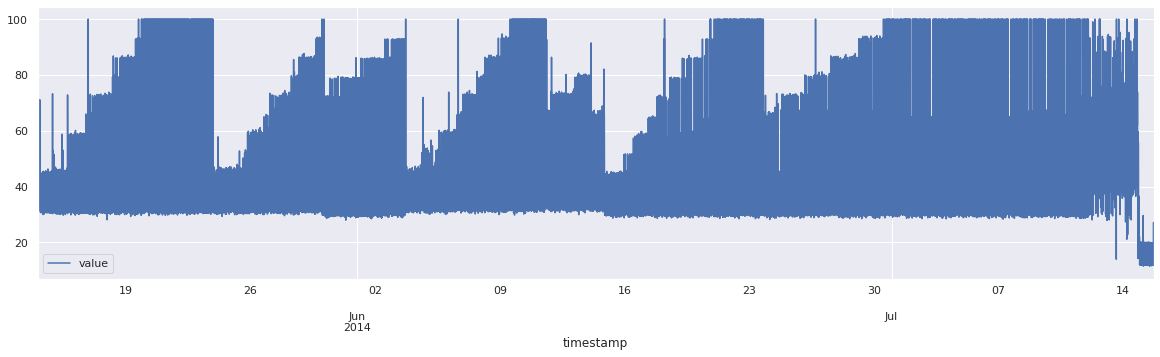

In [38]:
df_raw.plot(figsize=(20, 5))

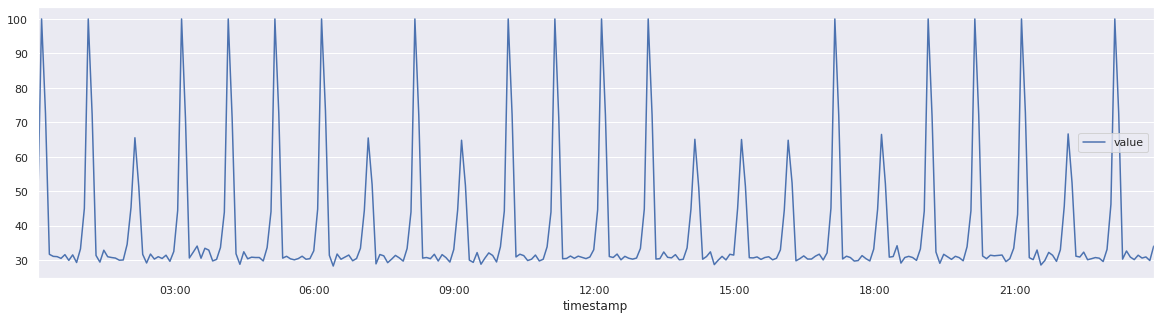

In [37]:
df_raw['2014-07-07'].plot(figsize=(20, 5))

In [61]:
df_raw['hour/min'] = df_raw.index.strftime('%H:%M:%S')
hour_mean = df_raw.groupby('hour/min')['value'].mean()

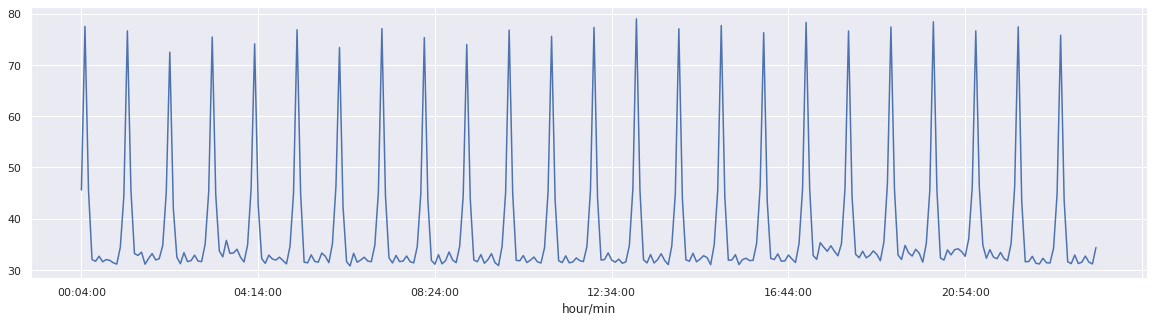

In [68]:
hour_mean.plot(figsize=(20, 5))

## MAD

In [77]:
df = df_raw

In [78]:
mad = MAD()
mad.fit(df['value'])
madscore = mad.decision_function(df['value'])
madpredict = mad.predict(df['value'])
madscore.head()

timestamp
2014-05-14 01:14:00    22.483612
2014-05-14 01:19:00    23.457565
2014-05-14 01:24:00     5.259847
2014-05-14 01:29:00    10.140888
2014-05-14 01:34:00     1.893194
Name: value, dtype: float64

Text(0.5, 1.0, 'MAD score - Por ponto')

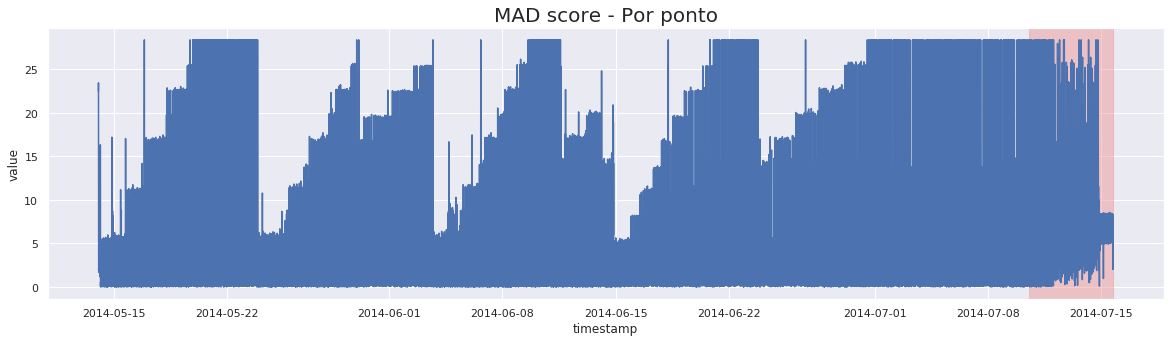

In [79]:
plot_anomalies(madscore, windows=labels)
plt.title("MAD score - Por ponto",fontsize=20)

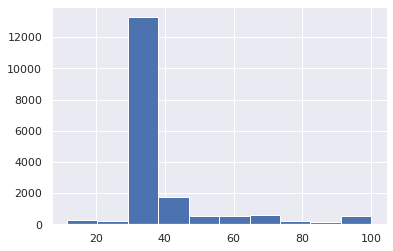

In [96]:
df['value'].hist()

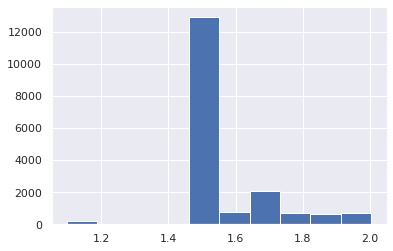

In [115]:
np.log10(df['value'] + 1).hist()

In [116]:
df_log = np.log10(df['value'] + 1)

mad = MAD()
mad.fit(df_log)
madscore = mad.decision_function(df_log)
madpredict = mad.predict(df_log)
madscore.head()

timestamp
2014-05-14 01:14:00    13.377098
2014-05-14 01:19:00    13.743527
2014-05-14 01:24:00     4.469673
2014-05-14 01:29:00     7.624802
2014-05-14 01:34:00     1.779646
Name: value, dtype: float64

Text(0.5, 1.0, 'MAD score - Por ponto')

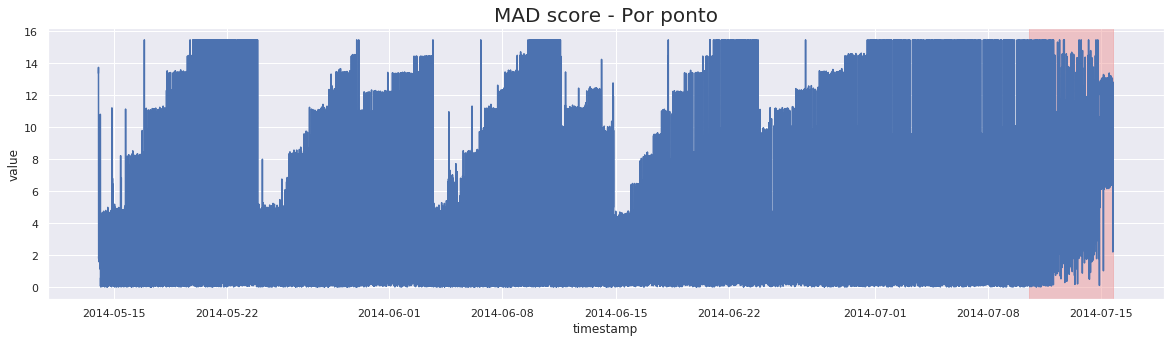

In [117]:
plot_anomalies(madscore, windows=labels)
plt.title("MAD score - Por ponto",fontsize=20)

Text(0.5, 1.0, 'MAD score - Por ponto')

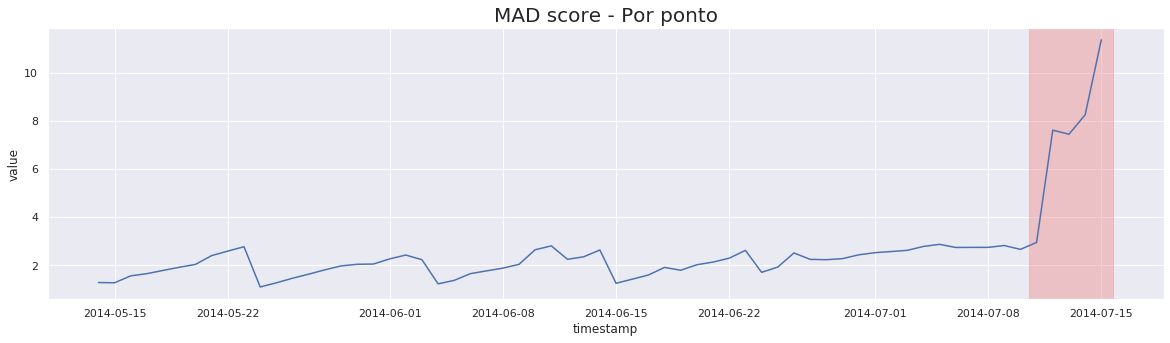

In [107]:
plot_anomalies(madscore.resample('D').mean(), windows=labels)
plt.title("MAD score - Por ponto",fontsize=20)

Text(0.5, 1.0, 'MAD score - Por ponto')

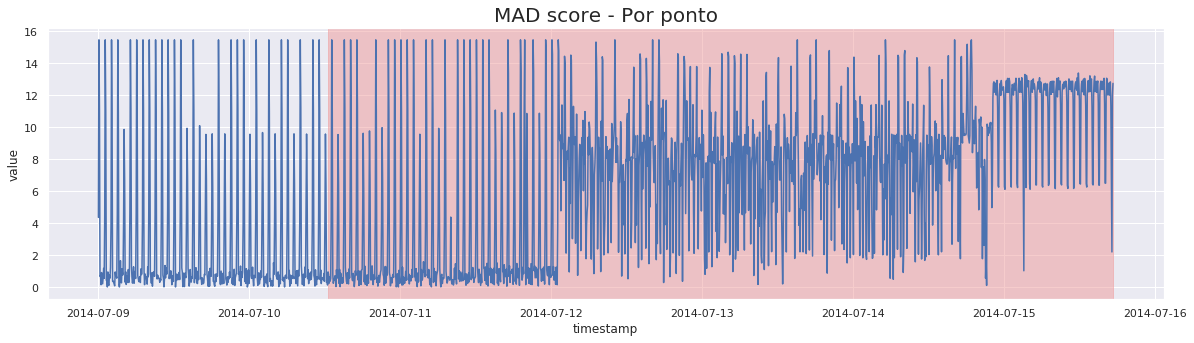

In [120]:
plot_anomalies(madscore['2014-07-09':], windows=labels)
plt.title("MAD score - Por ponto",fontsize=20)

## Tukey

In [121]:
tu = Tukey()
tu.fit(df['value'])
tupredict = tu.predict(df['value'])
tupredict.head()

timestamp
2014-05-14 01:14:00    85.835
2014-05-14 01:19:00    88.167
2014-05-14 01:24:00    44.595
2014-05-14 01:29:00    56.282
2014-05-14 02:04:00    49.724
Name: value, dtype: float64

Text(0.5, 1.0, 'Tukey score - Count do Dia')

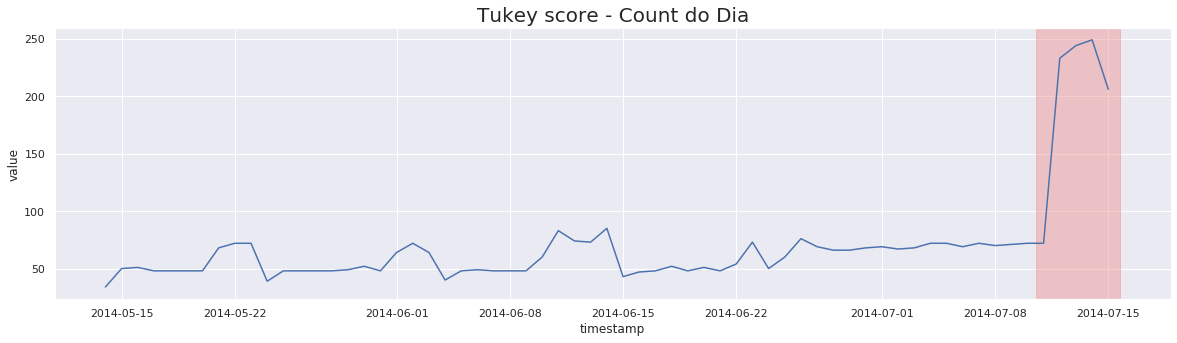

In [122]:
plot_anomalies(tupredict.resample('D').count().dropna(), windows=labels)
plt.title("Tukey score - Count do Dia",fontsize=20)

In [140]:
twitterscore = twitter_score(df['value'], period=12)
twitterscore

timestamp
2014-05-14 01:14:00    15.194430
2014-05-14 01:19:00    16.571089
2014-05-14 01:24:00     3.299739
2014-05-14 01:29:00     6.027335
2014-05-14 01:34:00     0.885989
                         ...    
2014-07-15 16:59:00     8.592343
2014-07-15 17:04:00     9.656119
2014-07-15 17:09:00     4.855267
2014-07-15 17:14:00     7.082160
2014-07-15 17:19:00     8.450495
Length: 18050, dtype: float64

Text(0.5, 1.0, 'Twitter score - Por ponto')

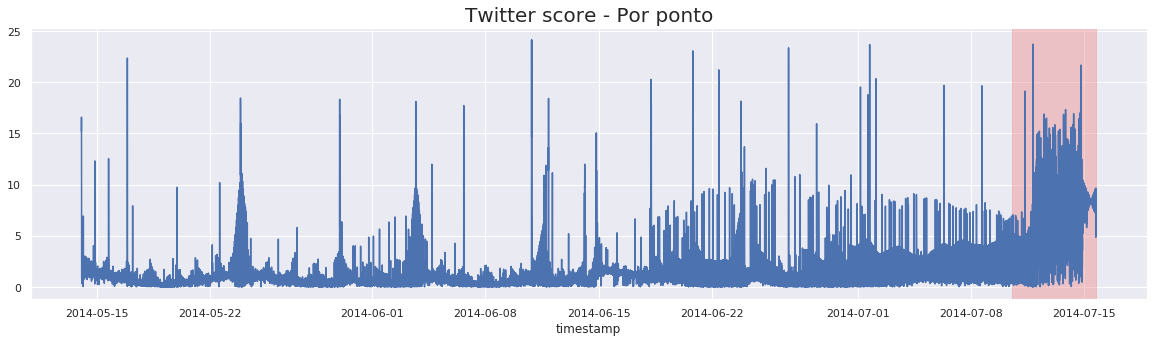

In [141]:
plot_anomalies(twitterscore, windows=labels)
plt.title("Twitter score - Por ponto",fontsize=20)

Text(0.5, 1.0, 'Twitter score - Média do Dia')

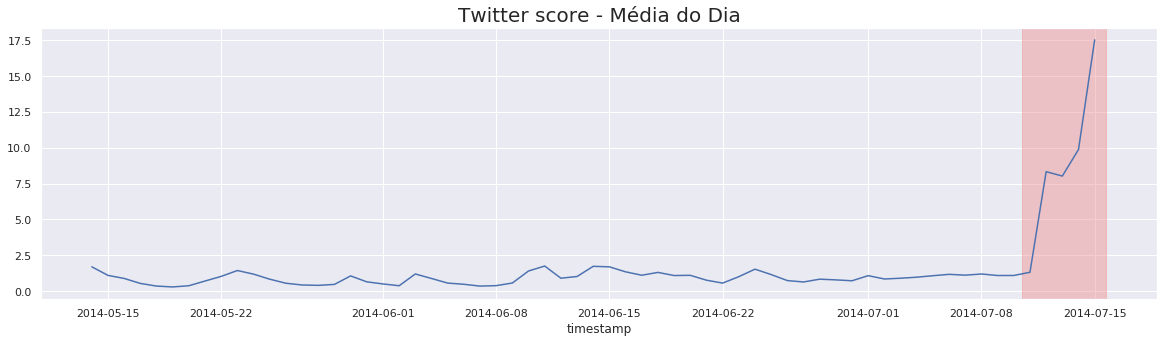

In [136]:
twitterday = twitterscore.resample('D').mean().dropna()

plot_anomalies(twitterday, windows=labels)
plt.title("Twitter score - Média do Dia",fontsize=20)